In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [3]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [4]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [5]:
from datetime import datetime as dt
start = dt.now()
# process stuff

from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)
running_secs = (dt.now() - start).seconds

4999 0.03566868230700493


In [6]:
running_secs

163

Text(0, 0.5, 'Loss')

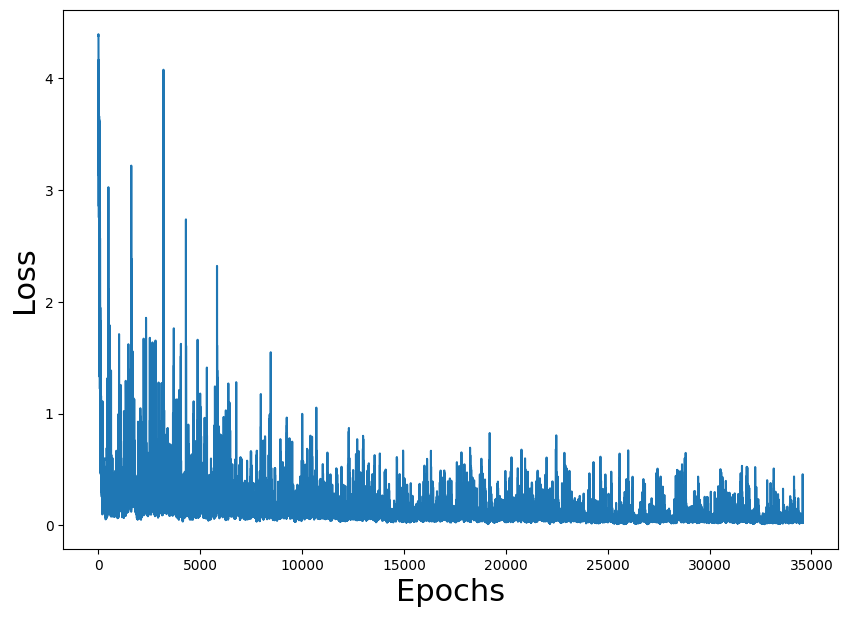

In [7]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [9]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [10]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 913
Win percentage: 91.3%


In [11]:
Q2

tensor([[ 5.6745,  7.8731,  6.0006,  6.2735],
        [ 2.1270,  1.6579,  1.2844,  1.0120],
        [10.2919,  4.8672,  3.2891,  6.3075],
        [ 4.7882,  5.1013,  5.4905,  8.2486],
        [ 5.9471,  7.8959,  6.1669,  4.7381],
        [ 4.1922,  7.3492,  8.0006,  4.9091],
        [ 7.5502,  4.6250,  5.8382,  7.8695],
        [10.4049,  6.4014,  5.8235,  5.4081],
        [ 6.8836,  3.4722,  5.0207,  6.0602],
        [-0.0994, -2.1062, -0.3757, -1.3986],
        [ 4.0664,  1.6791,  2.0570,  4.4760],
        [ 3.2061,  3.1623,  4.6015,  3.3528],
        [ 4.6296,  3.1711,  1.5952,  3.6614],
        [ 6.0680,  8.1178,  5.6533,  6.5984],
        [ 1.8690,  1.7533,  1.8506,  3.1568],
        [ 7.5744,  8.8968,  6.8076,  6.8408],
        [10.1345,  7.0020,  6.4738,  9.3601],
        [10.0708,  6.5952,  4.5006,  6.0148],
        [ 6.5080,  4.8491,  5.1680,  1.0396],
        [ 6.2325,  4.1186,  6.9993,  3.8160],
        [ 0.8741,  1.9649,  0.7360,  2.1455],
        [ 6.6746,  4.9677,  8.4211

In [12]:
game.board.render_np().reshape(1,16)

ValueError: cannot reshape array of size 64 into shape (1,16)

In [13]:
action_batch

tensor([2., 3., 2., 3., 2., 0., 3., 0., 0., 3., 0., 1., 3., 1., 2., 2., 3., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 1., 3., 2., 2., 0.,
        2., 0., 2., 0., 3., 0., 0., 0., 1., 2., 1., 0., 2., 2., 3., 2., 1., 3.,
        2., 1., 3., 1., 1., 0., 2., 3., 3., 3., 0., 2., 1., 3., 3., 0., 3., 3.,
        0., 1., 2., 1., 0., 1., 2., 2., 0., 1., 1., 2., 2., 2., 0., 0., 0., 1.,
        0., 2., 1., 2., 3., 0., 0., 3., 0., 1., 1., 1., 1., 0., 3., 2., 0., 3.,
        0., 1., 2., 1., 3., 3., 1., 0., 0., 0., 1., 0., 1., 3., 2., 0., 0., 1.,
        0., 1., 0., 3., 3., 2., 2., 1., 1., 0., 2., 2., 1., 0., 0., 3., 3., 0.,
        1., 3., 1., 0., 2., 0., 0., 2., 2., 0., 0., 3., 2., 0., 3., 2., 2., 2.,
        1., 1., 2., 0., 3., 0., 2., 0., 2., 2., 2., 3., 0., 3., 3., 0., 3., 0.,
        2., 2., 1., 0., 0., 0., 3., 0., 3., 0., 0., 2., 3., 0., 2., 3., 0., 1.,
        1., 0.])

In [14]:
torch.max(Q2,dim=1)[0][0].item()

7.8731255531311035

In [15]:
count = 0
for rew in reward_batch:
    print(count)
    print(rew)
    count = count + 1

0
tensor(-1.)
1
tensor(-1.)
2
tensor(-1.)
3
tensor(-1.)
4
tensor(-1.)
5
tensor(-1.)
6
tensor(-1.)
7
tensor(-1.)
8
tensor(-1.)
9
tensor(-1.)
10
tensor(-1.)
11
tensor(-1.)
12
tensor(-1.)
13
tensor(-1.)
14
tensor(-1.)
15
tensor(10.)
16
tensor(-1.)
17
tensor(-1.)
18
tensor(10.)
19
tensor(-1.)
20
tensor(-1.)
21
tensor(-1.)
22
tensor(10.)
23
tensor(-1.)
24
tensor(-1.)
25
tensor(-1.)
26
tensor(-1.)
27
tensor(-1.)
28
tensor(-1.)
29
tensor(-1.)
30
tensor(-1.)
31
tensor(-1.)
32
tensor(-1.)
33
tensor(-1.)
34
tensor(10.)
35
tensor(-1.)
36
tensor(-1.)
37
tensor(-1.)
38
tensor(-1.)
39
tensor(-1.)
40
tensor(-1.)
41
tensor(-1.)
42
tensor(-1.)
43
tensor(-1.)
44
tensor(-1.)
45
tensor(10.)
46
tensor(-1.)
47
tensor(-1.)
48
tensor(-1.)
49
tensor(-1.)
50
tensor(10.)
51
tensor(-1.)
52
tensor(-1.)
53
tensor(-1.)
54
tensor(10.)
55
tensor(-1.)
56
tensor(-1.)
57
tensor(10.)
58
tensor(-1.)
59
tensor(-1.)
60
tensor(-1.)
61
tensor(-1.)
62
tensor(-1.)
63
tensor(-1.)
64
tensor(-1.)
65
tensor(-1.)
66
tensor(-1.)
67
te

In [16]:
done_batch

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0.])

In [17]:
reward_batch

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., 10., -1., -1., 10., -1., -1., -1., 10., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., 10., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., 10., -1., -1., -1., -1., 10., -1., -1., -1., 10., -1.,
        -1., 10., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., 10., -1., -1., 10., 10.,
        -1., -1., 10., -1., -1., 10., -1., -1., -1., -1., 10., -1., -1., -1.,
        -1., -1., -1., -1., 10., -1., -1., -1., -1., 10., -1., -1., -1., -1.,
        -1., -1., 10., -1., -1., -1., 10., -1., -1., -1., -1., -1., -1., -1.,
        10., -1., -1., -1., -1., -1., -1., -1., 10., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 10., 10.,
        -1., 10., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 10., -1.,
        -1., -1., -1., -1., 10., 10., -1., -1., -1., -1., -1., -

In [18]:
state1_batch

tensor([[6.9924e-03, 4.6221e-03, 2.3260e-03,  ..., 8.3178e-03, 6.4344e-03,
         4.7479e-03],
        [9.9295e-03, 2.7734e-03, 7.6099e-03,  ..., 9.2810e-03, 5.2756e-04,
         9.2127e-03],
        [1.0122e-03, 8.2283e-03, 2.0635e-03,  ..., 2.8024e-03, 1.0030e+00,
         6.6720e-03],
        ...,
        [6.1207e-03, 3.4885e-03, 1.0000e+00,  ..., 4.1397e-03, 6.6260e-03,
         7.9839e-03],
        [5.2711e-03, 8.8724e-03, 4.1618e-03,  ..., 8.8268e-04, 4.8893e-03,
         8.4887e-03],
        [1.0053e-03, 4.7403e-03, 5.0623e-03,  ..., 7.4251e-03, 1.0009e+00,
         6.2102e-03]])

In [19]:
X

tensor([ 6.0766,  0.9882,  8.2187,  6.5304,  6.0456,  6.2535,  6.2134,  8.2946,
         5.0785, -1.2930,  2.9901,  3.1193,  3.3675,  6.4601,  1.8812,  9.8164,
         7.9254,  7.9684, 10.2082,  5.0588,  0.9740,  6.6486, 10.2344,  6.0601,
         7.7312,  6.4337,  7.8936,  2.9961,  3.3051,  1.8946,  8.1208,  6.1995,
         6.1057,  7.9710, 10.0294,  6.6371, -0.3751,  0.8859, -0.2136,  2.1597,
         5.8918,  1.0754,  4.8758,  8.2113,  4.8244, 10.0379,  3.5495,  6.9523,
         7.8679, -0.1798, 10.3134,  2.0190,  0.6667,  4.5099, 10.0420,  4.4373,
         3.3015, 10.2891,  4.7665,  8.2880,  4.5384,  8.2038,  4.5401,  1.0395,
         5.2309,  1.8513, -0.4969,  7.6773,  4.2339,  5.9560,  6.3075,  6.2817,
         6.9307,  8.2591,  6.1225, -1.3833,  1.8672,  5.1541,  8.1543, 10.2845,
         6.4208,  6.6217, 10.0689,  9.8381, -0.2561, -0.3757,  9.9000,  0.1671,
         2.9734, 10.0320,  6.3989,  6.1931,  3.3222,  4.6380, 10.1834,  8.0424,
        -8.7337,  4.3522,  4.6774,  7.92

In [20]:
Y

tensor([ 6.0858,  0.9143,  8.2627,  6.4238,  6.1063,  6.2006,  6.0826,  8.3644,
         5.1952, -1.0894,  3.0284,  3.1413,  3.1666,  6.3060,  1.8411, 10.0000,
         8.1211,  8.0637, 10.0000,  5.2994,  0.9309,  6.5790, 10.0000,  6.1904,
         7.7735,  6.6318,  8.0810,  3.0955,  3.4577,  1.8285,  8.1267,  6.2308,
         6.1386,  8.0845, 10.0000,  6.5665, -0.1684,  0.8049, -0.2231,  2.4161,
         6.1882,  0.9811,  4.6937,  8.2762,  4.9786, 10.0000,  3.6363,  6.8228,
         8.0265, -0.2527, 10.0000,  1.9301,  0.5845,  4.5738, 10.0000,  4.5315,
         1.7899, 10.0000,  4.7397,  8.2480,  4.5612,  8.1710,  4.4951,  0.8815,
         5.1883,  1.8481, -0.2243,  7.8500,  4.3881,  6.0965,  6.3873,  6.2136,
         6.9041,  8.9097,  6.4340, -1.1912,  1.7355,  5.1902,  8.3341, 10.0000,
         6.5267,  6.5862, 10.0000, 10.0000, -0.1971, -0.2369, 10.0000,  0.1391,
         3.0138, 10.0000,  6.4410,  6.1598,  3.3869,  4.0671, 10.0000,  8.2190,
        -9.0010,  4.6189,  4.7310,  8.01

In [21]:
w, h = 9, 200
matrix = [[0 for x in range(w)] for y in range(h)] 

In [22]:
Q1[0][3].item()

6.332633018493652

In [23]:
str(round(Q1[i][0].item(),3)) + "/" + str(Q1[i][1].item()) + "/" + str(Q1[i][2].item()) + "/" + str(Q1[i][3].item())

IndexError: index 999 is out of bounds for dimension 0 with size 200

In [24]:
matrix[50][0]

0

In [25]:
for i in range(0, 200):
    matrix[i][0] = str(round(Q1[i][0].item(),2)) + "/" + str(round(Q1[i][1].item(),2)) + "/" + str(round(Q1[i][2].item(),2)) + "/" + str(round(Q1[i][3].item(),2))
    matrix[i][1] = str(round(Q2[i][0].item(),2)) + "/" + str(round(Q2[i][1].item(),2)) + "/" + str(round(Q2[i][2].item(),2)) + "/" + str(round(Q2[i][3].item(),2))
    matrix[i][2] = action_batch[i].item()
    matrix[i][3] = reward_batch[i].item()
    matrix[i][4] = done_batch[i].item()
    matrix[i][5] = torch.max(Q2,dim=1)[0][i].item()
    matrix[i][6] = X[i].item()
    matrix[i][7] = Y[i].item()
    matrix[i][8] = gamma

In [26]:
import pandas as pd
column_names = ["Q1_arr", "Q2_arr", "Action", "Reward", "Done", "Q_max", "X", "Y", "Gamma"
                ]
df = pd.DataFrame(matrix, columns = column_names)

In [27]:
df

,Q1_arr,Q2_arr,Action,Reward,Done,Q_max,X,Y,Gamma
0,5.73/7.94/6.08/6.33,5.67/7.87/6.0/6.27,2.0,-1.0,0.0,7.873126,6.076590,6.085813,0.9
1,2.1/1.63/1.26/0.99,2.13/1.66/1.28/1.01,3.0,-1.0,0.0,2.126988,0.988210,0.914289,0.9
2,0.61/1.61/8.22/1.45,10.29/4.87/3.29/6.31,2.0,-1.0,0.0,10.291929,8.218711,8.262736,0.9
3,2.76/3.63/4.3/6.53,4.79/5.1/5.49/8.25,3.0,-1.0,0.0,8.248628,6.530395,6.423765,0.9
4,4.74/4.82/6.05/2.08,5.95/7.9/6.17/4.74,2.0,-1.0,0.0,7.895865,6.045648,6.106279,0.9
...,...,...,...,...,...,...,...,...,...
195,6.6/8.07/5.85/10.35,6.09/2.55/6.07/3.25,3.0,10.0,1.0,6.094788,10.352382,10.000000,0.9
196,6.37/4.82/4.78/4.2,8.2/6.57/7.39/4.1,0.0,-1.0,0.0,8.195777,6.367819,6.376199,0.9
197,7.49/9.94/6.6/6.91,5.08/6.4/4.15/4.83,1.0,10.0,1.0,6.401919,9.940571,10.000000,0.9
198,2.94/6.25/-3.04/3.57,4.49/8.14/4.86/7.31,1.0,-1.0,0.0,8.136497,6.254714,6.322847,0.9


In [37]:
df.to_csv('Experience Replay Representation.csv')

In [29]:
Y.detach()

tensor([ 6.0858,  0.9143,  8.2627,  6.4238,  6.1063,  6.2006,  6.0826,  8.3644,
         5.1952, -1.0894,  3.0284,  3.1413,  3.1666,  6.3060,  1.8411, 10.0000,
         8.1211,  8.0637, 10.0000,  5.2994,  0.9309,  6.5790, 10.0000,  6.1904,
         7.7735,  6.6318,  8.0810,  3.0955,  3.4577,  1.8285,  8.1267,  6.2308,
         6.1386,  8.0845, 10.0000,  6.5665, -0.1684,  0.8049, -0.2231,  2.4161,
         6.1882,  0.9811,  4.6937,  8.2762,  4.9786, 10.0000,  3.6363,  6.8228,
         8.0265, -0.2527, 10.0000,  1.9301,  0.5845,  4.5738, 10.0000,  4.5315,
         1.7899, 10.0000,  4.7397,  8.2480,  4.5612,  8.1710,  4.4951,  0.8815,
         5.1883,  1.8481, -0.2243,  7.8500,  4.3881,  6.0965,  6.3873,  6.2136,
         6.9041,  8.9097,  6.4340, -1.1912,  1.7355,  5.1902,  8.3341, 10.0000,
         6.5267,  6.5862, 10.0000, 10.0000, -0.1971, -0.2369, 10.0000,  0.1391,
         3.0138, 10.0000,  6.4410,  6.1598,  3.3869,  4.0671, 10.0000,  8.2190,
        -9.0010,  4.6189,  4.7310,  8.01

In [30]:
loss = loss_fn(X, Y.detach())
loss

tensor(0.0357, grad_fn=<MseLossBackward0>)

In [31]:
>>> loss = torch.nn.MSELoss()
>>> input = torch.randn(3, 1, requires_grad=True)
>>> target = torch.randn(3, 1)
>>> output = loss(input, target)
output

tensor(2.9886, grad_fn=<MseLossBackward0>)

In [32]:
input

tensor([[-0.4920],
        [-0.5641],
        [ 1.1437]], requires_grad=True)

In [33]:
target

tensor([[ 0.1227],
        [ 1.2877],
        [-1.1276]])

In [34]:
x = (input - target) * (input - target)
(x[0] + x[1] + x[2]) / 3

tensor([2.9886], grad_fn=<DivBackward0>)

In [35]:
output

tensor(2.9886, grad_fn=<MseLossBackward0>)

In [36]:
state1_batch[0]

tensor([6.9924e-03, 4.6221e-03, 2.3260e-03, 4.9835e-03, 1.0036e+00, 8.9813e-03,
        4.6531e-03, 4.2916e-03, 4.8802e-03, 4.9222e-03, 8.0256e-03, 4.3602e-03,
        5.5903e-03, 5.6181e-04, 9.4816e-03, 4.0730e-03, 2.1150e-03, 5.2645e-03,
        9.4040e-03, 7.2750e-03, 7.6120e-03, 6.3084e-03, 2.1906e-03, 2.7271e-03,
        2.2498e-03, 1.0059e+00, 4.1569e-04, 9.6440e-04, 1.4637e-03, 8.2249e-03,
        2.5938e-03, 5.6132e-03, 2.7768e-03, 1.9583e-03, 5.5750e-04, 1.0009e+00,
        3.5800e-03, 3.8546e-03, 4.3417e-03, 9.1206e-03, 1.5417e-03, 6.4400e-03,
        5.4832e-03, 3.7958e-03, 9.3324e-03, 4.7852e-03, 5.1735e-03, 3.5503e-03,
        2.6831e-03, 6.4691e-03, 2.8980e-03, 3.3983e-03, 2.1349e-03, 1.0077e+00,
        7.1840e-04, 8.6235e-03, 5.7020e-03, 3.2900e-03, 7.9327e-03, 7.4266e-03,
        1.5761e-03, 8.3178e-03, 6.4344e-03, 4.7479e-03])